# Linear Sequential Estimation

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(1)

In [3]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Generate sample time series data

In [4]:
t = np.linspace(0, 6, 500)
x = np.array([[1, 1, 2, -0.4e-4]]).T
H = np.vstack([t, np.sin(t), np.cos(2*t), np.exp(t)]).T
y = H@x

# Add some normal (gaussian) noise

In [5]:
# Example for Gaussian (normal) random variable

noise_mean = 0
noise_std = 0.5

v = np.column_stack(np.random.normal(noise_mean, noise_std, len(y))).T

In [6]:
y_tilde = y+v

# Plotting

<Axes: xlabel='Time', ylabel='y'>

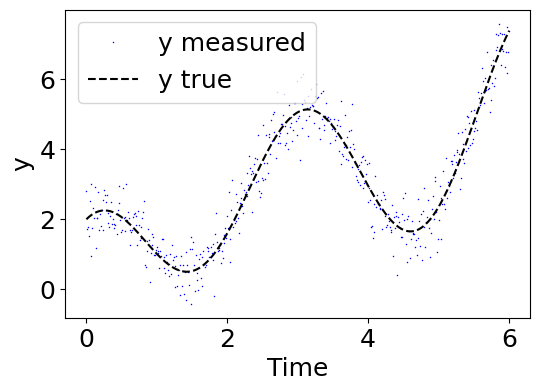

In [7]:
plot_tme(t, y, y_tilde)

# Candidate models

In [8]:
model_1_H = np.vstack([t, np.sin(t), np.cos(2*t)]).T

# Exercise

Implement Linear Sequential Estimation, and plot the three parameters of $x$ over time

$\hat{x_{k+1}} = \hat{x}_k + K_{k+1} (̃\tilde{y_{k+1}}) -H_{k+1} \cdot ̂\hat{x}_k$

In [9]:
I = np.array([[1,0,0],
              [0,1,0],
              [0,0,1]])
W = 1


# Task
Implement linear sequential estimation (Kalman filter) to estimate the parameters of a linear system given noisy measurements.

In [20]:
def update(x_k, P_k, H_k, y_k_plus_1, R):

    # Ensure proper dimensions
    H_k = H_k.reshape(1, -1)  # Make sure H is (1x3)
    y_k_plus_1 = float(y_k_plus_1)  # Make sure y is scalar

    # Prediction step (for parameters, no state transition)
    x_pred = x_k.copy()
    P_pred = P_k.copy()  # No process noise for constant parameters

    # Innovation (measurement residual)
    innovation = y_k_plus_1 - (H_k @ x_pred)[0, 0]

    # Innovation covariance
    S = (H_k @ P_pred @ H_k.T)[0, 0] + R

    # Kalman gain
    K = (P_pred @ H_k.T) / S

    # Update state estimate
    x_k_plus_1 = x_pred + K * innovation

    # Update covariance matrix
    I_KH = np.eye(3) - K @ H_k
    P_k_plus_1 = I_KH @ P_pred @ I_KH.T + (K @ K.T) * R

    return x_k_plus_1, P_k_plus_1


In [21]:
def run_sequential_estimation():
    """Run the sequential estimation on your data"""

    # Initialize estimates (poor initial guess)
    x_est = np.array([[0.0], [0.0], [0.0]])  # 3x1
    P_est = np.eye(3) * 10.0  # 3x3, high initial uncertainty
    R = noise_std**2  # Measurement noise variance

    # True parameters for model_1 (first 3 components of original x)
    x_true_model1 = x[:3]  # [1, 1, 2]

    # Storage for results
    n_steps = len(t)
    x_history = np.zeros((n_steps, 3))
    P_trace_history = np.zeros(n_steps)  # Trace of covariance matrix

    print("Running Sequential Estimation...")
    print(f"True parameters for model_1: {x_true_model1.flatten()}")
    print(f"Measurement noise std: {noise_std}")

    # Generate measurements for model_1 (only first 3 terms)
    y_model1 = model_1_H @ x_true_model1
    y_model1_noisy = y_model1 + v  # Add same noise

    # Sequential processing
    for k in range(n_steps):
        # Get measurement matrix and measurement for current time
        H_k = model_1_H[k, :]  # Current row (1x3)
        y_k = y_model1_noisy[k, 0]  # Current measurement (scalar)

        # Update estimate
        x_est, P_est = update(x_est, P_est, H_k, y_k, R)

        # Store results
        x_history[k] = x_est.flatten()
        P_trace_history[k] = np.trace(P_est)

    return x_history, P_trace_history, y_model1_noisy, y_model1

# Run the estimation
x_history, P_trace_history, y_model1_noisy, y_model1 = run_sequential_estimation()


Running Sequential Estimation...
True parameters for model_1: [1. 1. 2.]
Measurement noise std: 0.5


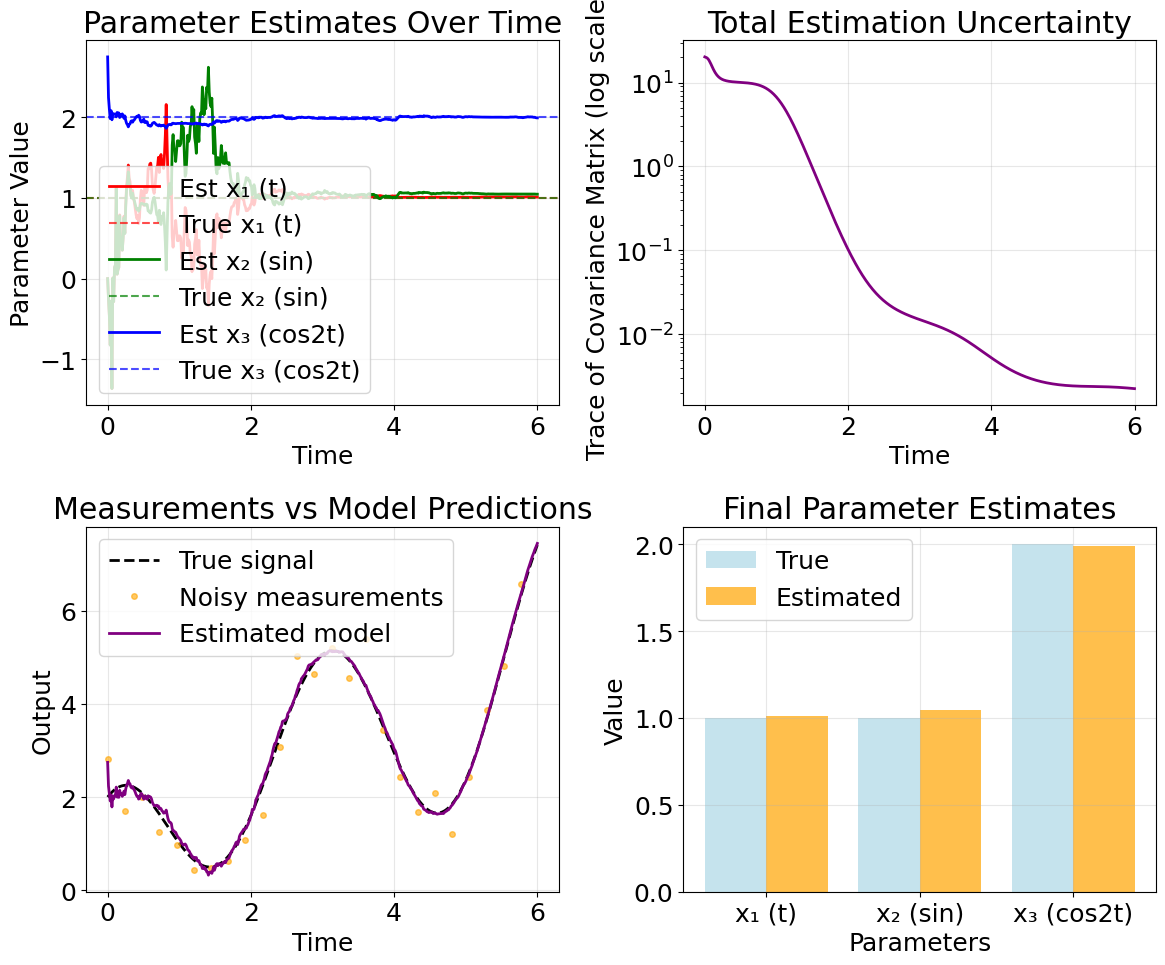


=== FINAL RESULTS ===
True parameters:     [1.000, 1.000, 2.000]
Final estimates:     [1.009, 1.045, 1.989]
Absolute errors:     [0.009, 0.045, 0.011]
Relative errors (%): [0.9, 4.5, 0.5]

=== EXAMPLE: Manual update function usage ===
Before update: x = [0. 0. 0.]
After update:  x = [0.        0.        2.6782597]
Measurement used: 2.812
H matrix used: [0. 0. 1.]


In [22]:

# Plot results
#fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Parameter estimates over time
#ax = axes[0, 0]
true_params = [1, 1, 2]  # First 3 parameters
param_names = ['x₁ (t)', 'x₂ (sin)', 'x₃ (cos2t)']
colors = ['red', 'green', 'blue']

for i in range(3):
    ax.plot(t, x_history[:, i], color=colors[i], linewidth=2,
            label=f'Est {param_names[i]}')
    ax.axhline(true_params[i], color=colors[i], linestyle='--',
               alpha=0.7, label=f'True {param_names[i]}')

ax.set_xlabel('Time')
ax.set_ylabel('Parameter Value')
ax.set_title('Parameter Estimates Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Estimation uncertainty (trace of covariance)
ax = axes[0, 1]
ax.semilogy(t, P_trace_history, 'purple', linewidth=2)
ax.set_xlabel('Time')
ax.set_ylabel('Trace of Covariance Matrix (log scale)')
ax.set_title('Total Estimation Uncertainty')
ax.grid(True, alpha=0.3)

# Plot 3: Measurements vs predictions
ax = axes[1, 0]
# Model predictions using estimated parameters
y_predicted = np.array([model_1_H[k] @ x_history[k].reshape(-1, 1)
                       for k in range(len(t))]).flatten()

ax.plot(t, y_model1.flatten(), 'k--', linewidth=2, label='True signal')
ax.plot(t[::20], y_model1_noisy[::20], 'o', color='orange', markersize=4,
        alpha=0.6, label='Noisy measurements')
ax.plot(t, y_predicted, 'purple', linewidth=2, label='Estimated model')
ax.set_xlabel('Time')
ax.set_ylabel('Output')
ax.set_title('Measurements vs Model Predictions')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Final parameter comparison
ax = axes[1, 1]
x_pos = np.arange(3)
final_estimates = x_history[-1]
ax.bar(x_pos - 0.2, true_params, 0.4, label='True', alpha=0.7, color='lightblue')
ax.bar(x_pos + 0.2, final_estimates, 0.4, label='Estimated', alpha=0.7, color='orange')
ax.set_xlabel('Parameters')
ax.set_ylabel('Value')
ax.set_title('Final Parameter Estimates')
ax.set_xticks(x_pos)
ax.set_xticklabels(param_names)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print("\n=== FINAL RESULTS ===")
true_params = np.array([1, 1, 2])
final_estimates = x_history[-1]
errors = np.abs(final_estimates - true_params)
relative_errors = errors / np.abs(true_params) * 100

print(f"True parameters:     [{true_params[0]:.3f}, {true_params[1]:.3f}, {true_params[2]:.3f}]")
print(f"Final estimates:     [{final_estimates[0]:.3f}, {final_estimates[1]:.3f}, {final_estimates[2]:.3f}]")
print(f"Absolute errors:     [{errors[0]:.3f}, {errors[1]:.3f}, {errors[2]:.3f}]")
print(f"Relative errors (%): [{relative_errors[0]:.1f}, {relative_errors[1]:.1f}, {relative_errors[2]:.1f}]")

# Example of how to use the update function manually
print("\n=== EXAMPLE: Manual update function usage ===")
# Initialize
x_k = np.array([[0.0], [0.0], [0.0]])
P_k = np.eye(3) * 5.0
H_k = model_1_H[0, :]  # First measurement matrix
y_k_plus_1 = y_model1_noisy[0, 0]  # First measurement
R = noise_std**2

# Single update
x_k_plus_1, P_k_plus_1 = update(x_k, P_k, H_k, y_k_plus_1, R)

print(f"Before update: x = {x_k.flatten()}")
print(f"After update:  x = {x_k_plus_1.flatten()}")
print(f"Measurement used: {y_k_plus_1:.3f}")
print(f"H matrix used: {H_k}")